
Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?


In [1]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [4]:
PATH_image = 'original_images'
PATH_label = 'label_images_semantic'

In [5]:
import os, fnmatch
imag = os.listdir(PATH_image)
imag_label = os.listdir(PATH_label)

In [6]:
%%time

images = list()
segments = list()
image_size = (384,640)
i=0

for i_name in imag:
    images.append(image.load_img(PATH_image+'/'+i_name, target_size=image_size))    
    segments.append(image.load_img(PATH_label+'/'+i_name[:-3]+'png', target_size=image_size))
    i=i+1
    if i % 50 == 0:
      print(i_name)

077.jpg
149.jpg
216.jpg
292.jpg
372.jpg
445.jpg
525.jpg
598.jpg
Wall time: 3min 35s


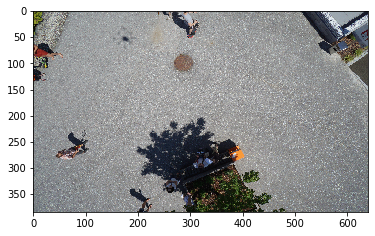

In [7]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

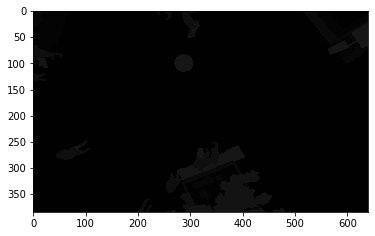

In [8]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [9]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)
print(xTrain_Test.shape)

(400, 384, 640, 3)


In [10]:
yTrain_Test = []

for seg in segments:  
  y = image.img_to_array(seg)
  yTrain_Test.append(y[:, :, 0])

yTrain_Test = np.array(yTrain_Test)
print(yTrain_Test.shape)

(400, 384, 640)


In [11]:
num_classes = len(np.unique(yTrain_Test[:, :, :]))

In [12]:
yTrain_Test_cat = keras.utils.to_categorical(yTrain_Test, num_classes)

In [13]:
print(yTrain_Test_cat.shape)

(400, 384, 640, 23)


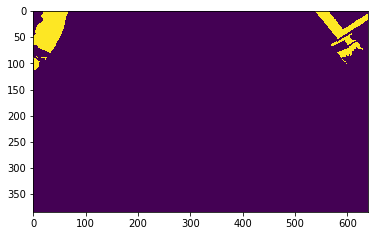

In [14]:
plt.imshow(yTrain_Test_cat[0,:,:,4])
plt.show()

In [15]:
N = 300
yTrain = yTrain_Test_cat[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test_cat[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [16]:
pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 160, 128)      0     

In [17]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers:
      layer.trainable = False
    x = pre_trained_model.layers[18].output
    block_5_out = pre_trained_model.layers[14].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_5_out)
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    
    # UP 0
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_5_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef, 'accuracy'])
    model.summary()
    return model

In [26]:
modelU = unet_pre_train(num_classes=num_classes, input_shape=xTest.shape[1:])

Tensor("block4_pool/MaxPool_2:0", shape=(None, 24, 40, 512), dtype=float32)
Tensor("block3_pool/MaxPool_2:0", shape=(None, 48, 80, 256), dtype=float32)
Tensor("block2_pool/MaxPool_2:0", shape=(None, 96, 160, 128), dtype=float32)
Tensor("block1_pool/MaxPool_2:0", shape=(None, 192, 320, 64), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 640, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 640, 64) 36928       block1_conv1[

In [27]:
%%time

callback = EarlyStopping(monitor='val_dice_coef', patience=10, mode='max')
history = modelU.fit(xTrain, yTrain, epochs=50, batch_size=2, validation_data=(xTrain, yTrain), callbacks=[callback])

Epoch 1/50
150/150 [==============================] - 217s 1s/step - loss: 1.5925 - dice_coef: 0.3973 - accuracy: 0.5443 - val_loss: 2.7487 - val_dice_coef: 0.2162 - val_accuracy: 0.2670
Epoch 2/50
150/150 [==============================] - 228s 2s/step - loss: 1.3150 - dice_coef: 0.4751 - accuracy: 0.6065 - val_loss: 1.5218 - val_dice_coef: 0.4111 - val_accuracy: 0.5367
Epoch 3/50
150/150 [==============================] - 228s 2s/step - loss: 1.2267 - dice_coef: 0.4996 - accuracy: 0.6249 - val_loss: 1.1728 - val_dice_coef: 0.5073 - val_accuracy: 0.6437
Epoch 4/50
150/150 [==============================] - 226s 2s/step - loss: 1.1210 - dice_coef: 0.5325 - accuracy: 0.6503 - val_loss: 1.4527 - val_dice_coef: 0.4039 - val_accuracy: 0.5206
Epoch 5/50
150/150 [==============================] - 229s 2s/step - loss: 1.0348 - dice_coef: 0.5635 - accuracy: 0.6773 - val_loss: 0.9638 - val_dice_coef: 0.5621 - val_accuracy: 0.6755
Epoch 6/50
150/150 [==============================] - 229s 2s/ste

Epoch 42/50
150/150 [==============================] - 194s 1s/step - loss: 0.4067 - dice_coef: 0.8176 - accuracy: 0.8722 - val_loss: 0.5471 - val_dice_coef: 0.7622 - val_accuracy: 0.8234
Epoch 43/50
150/150 [==============================] - 194s 1s/step - loss: 0.3664 - dice_coef: 0.8352 - accuracy: 0.8846 - val_loss: 0.4837 - val_dice_coef: 0.7730 - val_accuracy: 0.8442
Epoch 44/50
150/150 [==============================] - 193s 1s/step - loss: 0.3528 - dice_coef: 0.8407 - accuracy: 0.8896 - val_loss: 0.4403 - val_dice_coef: 0.7972 - val_accuracy: 0.8543
Epoch 45/50
150/150 [==============================] - 194s 1s/step - loss: 0.3420 - dice_coef: 0.8464 - accuracy: 0.8920 - val_loss: 0.5239 - val_dice_coef: 0.7862 - val_accuracy: 0.8321
Epoch 46/50
150/150 [==============================] - 193s 1s/step - loss: 0.3480 - dice_coef: 0.8432 - accuracy: 0.8897 - val_loss: 0.4705 - val_dice_coef: 0.7972 - val_accuracy: 0.8527
Epoch 47/50
150/150 [==============================] - 193s 

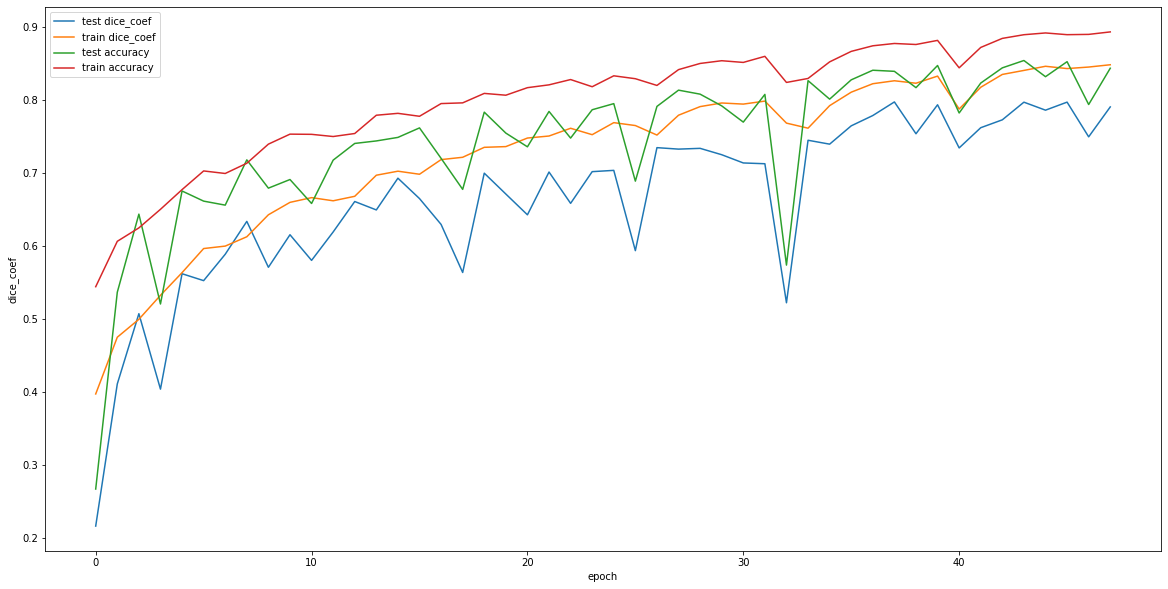

In [28]:
plt.figure(figsize =(20,10))
plt.plot(history.history['val_dice_coef'],label = 'test dice_coef')
plt.plot(history.history['dice_coef'],label='train dice_coef')
plt.plot(history.history['val_accuracy'],label = 'test accuracy')
plt.plot(history.history['accuracy'],label='train accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [30]:
predu = modelU.predict(xTest)
print(predu.shape)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,384,640] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_3/block1_conv1/Relu (defined at <ipython-input-29-28c726daa8d8>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_61625]

Function call stack:
predict_function


Не хватает памяти. Понизил выборку

In [34]:
N=390
yTest2 = yTrain_Test_cat[N:,:,:,:]
xTest2 = xTrain_Test[N:,:,:,:]

predu = modelU.predict(xTest2)
print(predu.shape)

(10, 384, 640, 23)


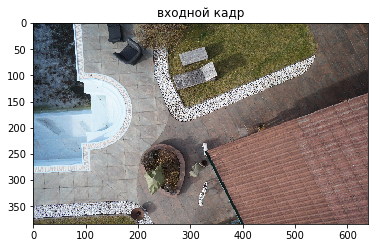

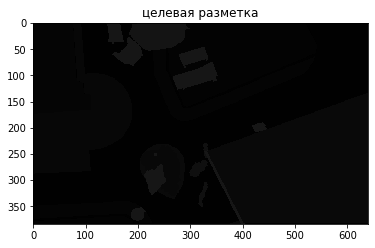

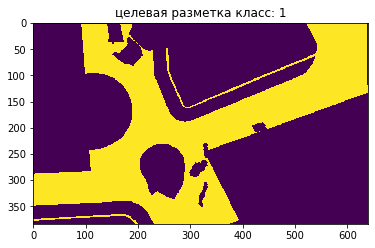

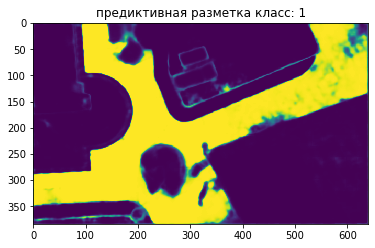

In [36]:
n = 0
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest2[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

Модели нужно больше данных и ресурсов, но моя техника не в состоянии такое считать.